<h1 align='center'> College "Snack" Demand Generation </h1>

Simulated Demands for "daily Ice Cream" snack at a hypothetical "university" with __N_students__ students.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from numpy.random import choice, rand, uniform

import tqdm.notebook as tqdm

__Scenario:__ A campus of $N$ students, where each student 
1. Takes 15 hours of classes ( = 5 courses at 3 hours each)
2. Obtains lunch either from the "commons" or from one of a number of local food trucks
3. Often gets something "on the fly" from an ice cream or coffee vendor 


In [36]:
ScheduleTimes = {('M','W','F'):[8,9,10,11,12,13,14,15,16],  #Military time
                 ('T','R'):[8,9.5,11,12.5,14,15.5]  }  #classes are 1.5 hours on TR 

MWF = [8,9,10,11,12,13,14,15,16]
TR  = [8,9.5,11,12.5,14,15.5]

In [37]:
μ_demand = 500  # Assuming No Features 
RANDOM_SEED = 42

SIM_TIME = 300 # minutes per day
SIM_START = 10.  # hours
SIM_END   = 15.  # hours
N_students = 10_000
nclasses = 5  # number of courses each student takes 
pTR = 2/3 # probability of scheduling a course on a Tuesday or Thursday



class CollegeStudent(object):
    """A template for the features relevant to buying either ice cream or 
    hot chocolate for a student at a university with $N$ students"""
    
    def __init__(self, p_NoFeatures = μ_demand/N_students ):    
        '''Construct the Features that motivate a student to buy either icecream or hot chocolate '''
        ## Initialize 
        self.p_MWF = p_NoFeatures / (1-pTR)
        self.p_TR  = p_NoFeatures / pTR
            
        ## Build Schedule 
        MWF = [8.,9.,10.,11.,12.,13.,14.,15.,16.]
        TR  = [8.,9.5,11.,12.5,14.,15.5]
        self.sched = {'MWF':[],'TR':[]}
        for i in range(nclasses):
            if( rand() < pTR and len(self.sched['TR']) < 5 ):
                ## Force at least one MWF course -- if all courses are TR, 
                ## then no times on MWTRF that student goes to vendor
                crse = choice(TR)
                self.sched['TR'].append(crse)
                TR.remove(crse)
            else:
                crse = choice(MWF)
                self.sched['MWF'].append(crse)
                MWF.remove(crse)
        if( len(self.sched['MWF']) > 0 ): self.sched['MWF'].sort()
        if( len(self.sched['TR'] ) > 0 ): self.sched['TR' ].sort()
            
        ## pairs start time and menu choice
        self.FoodOps = dict()  # At most 1 per day
        for day in ['M','T','W','R','F']:
            self.FoodOps[day] = []
            daydur = ('MWF',1.0) if day in ['M','W','F'] else ('TR',1.5)
                 
            ndurs = len(self.sched[daydur[0]])
            if( ndurs == 0): continue 
            
            ## Food Ops between 10 a.m. and 3 p.m. 
            if( self.sched[daydur[0]][0] > SIM_START):
                self.FoodOps[day].append( (SIM_START, self.sched[daydur[0]][0] ) ) 

            for i in range( ndurs ):
                start_time = max(10,self.sched[daydur[0]][i] + daydur[1])
                if( i+1 < ndurs ): 
                    end_time = min(SIM_END, self.sched[daydur[0]][i+1])
                else:
                    end_time = SIM_END 
                if( start_time < end_time):
                    self.FoodOps[day].append( (start_time, end_time) )
    
    def GetSnackTime(self,day):
        ## Negative if no snack time available that day
        if(len(self.FoodOps[day]) > 0):
            snackperiod = self.FoodOps[day][choice(range(len(self.FoodOps[day])))]
            return np.round(uniform(*snackperiod),4)
        else:
            return -1
            
    
    def BuyIceCream(self, day, FeatureScales = None, ignore = False ):  # does student buy ice cream at time t
        """Student Decides to buy ice cream or not: 
        
        returns Number_purchased  """
        if( day in ['T','R'] ): 
            p = self.p_TR  
        else:
            p = self.p_MWF 
        odds = p/(1-p) ## Features increase or decrease the odds 
            
        if( len(self.FoodOps[day]) == 0):
            return 0 ## Nothing purchased this day
        if( not ignore ):  #Ignore all features other than what day it is
            ## Features Scale Proportionally 
            WinLen = 0
            for per in self.FoodOps[day]:
                WinLen += 60*(per[1] - per[0]) ## in minutes
            odds = odds * WinLen / SIM_TIME  ## restricted opporunity decreases the odds 

            if(np.iterable(FeatureScales) ):
                for scaler in FeatureScales:
                    odds *= scaler  # scalers are positive ( not zero )
                    
        p = odds/(odds + 1)  # tranform back to a probability
        if( rand() < p):
            return 1  #buys one ice cream
        else:
            return 0
                
    def __repr__(self):
        return self.sched.__repr__() + '\n' + self.FoodOps.__repr__()

In [38]:
Fred = CollegeStudent()
Fred

{'MWF': [9.0, 10.0, 14.0, 16.0], 'TR': [11.0]}
{'M': [(11.0, 14.0)], 'T': [(10.0, 11.0), (12.5, 15.0)], 'W': [(11.0, 14.0)], 'R': [(10.0, 11.0), (12.5, 15.0)], 'F': [(11.0, 14.0)]}

In [39]:
Fred.GetSnackTime('M')

13.8844

In [40]:
Fred.BuyIceCream('M')

0

In [42]:
DailyData = pd.read_csv('ETSU2020-2021AcademicYear.csv', index_col=0)
DailyData.head(100)

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
Date time,,,,,,,,,,,,,,,
8/24/2020,86.5,66.4,74.8,NaN,88.9,0.00,0.00,0.00,6.4,139.25,16.1,8.9,57.1,77.67,Partially cloudy
8/25/2020,87.8,66.8,76.6,NaN,89.2,0.00,0.00,0.00,10.4,207.71,23.0,9.4,41.4,74.50,Partially cloudy
8/26/2020,89.0,65.6,76.5,NaN,91.5,0.00,0.00,0.00,6.9,191.42,16.1,9.1,39.4,76.62,Partially cloudy
8/27/2020,86.9,66.8,76.4,NaN,91.1,0.00,0.00,0.00,10.4,158.04,19.7,8.9,52.0,80.55,Partially cloudy
8/28/2020,85.4,68.2,76.3,NaN,90.3,0.42,0.00,0.00,6.5,150.79,11.4,8.5,49.8,82.33,"Rain, Partially cloudy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/27/2020,59.8,35.7,46.1,NaN,NaN,0.00,0.00,0.00,8.8,143.59,19.7,7.9,47.2,80.61,Partially cloudy
11/28/2020,59.3,38.8,48.6,39.1,NaN,0.00,0.00,0.00,6.8,161.50,23.0,9.9,40.7,70.48,Partially cloudy
11/29/2020,57.6,32.4,44.8,44.3,NaN,0.01,0.00,0.00,5.1,37.96,NaN,9.6,51.7,74.01,"Rain, Partially cloudy"


In [45]:
columns = DailyData.columns
columns

Index(['Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Wind Chill', 'Heat Index', 'Precipitation', 'Snow', 'Snow Depth',
       'Wind Speed', 'Wind Direction', 'Wind Gust', 'Visibility',
       'Cloud Cover', 'Relative Humidity', 'Conditions', 'Day'],
      dtype='object')

In [46]:
WkDays = ['M','T','W','R','F']*100
DailyData['Day'] = WkDays[:len(DailyData)]
DailyDf = DailyData[['Day','Maximum Temperature', 'Minimum Temperature', 'Wind Chill', 'Heat Index', 'Precipitation',
       'Wind Speed',  'Cloud Cover', 'Relative Humidity']]
DailyDf.head()

,Day,Maximum Temperature,Minimum Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Cloud Cover,Relative Humidity
Date time,,,,,,,,,
8/24/2020,M,86.5,66.4,NaN,88.9,0.00,6.4,57.1,77.67
8/25/2020,T,87.8,66.8,NaN,89.2,0.00,10.4,41.4,74.50
8/26/2020,W,89.0,65.6,NaN,91.5,0.00,6.9,39.4,76.62
8/27/2020,R,86.9,66.8,NaN,91.1,0.00,10.4,52.0,80.55
8/28/2020,F,85.4,68.2,NaN,90.3,0.42,6.5,49.8,82.33


In [47]:
DailyDf.describe()

,Maximum Temperature,Minimum Temperature,Wind Chill,Heat Index,Precipitation,Wind Speed,Cloud Cover,Relative Humidity
count,250.000000,250.000000,149.000000,25.00000,250.000000,250.000000,250.000000,250.000000
mean,60.806400,40.831600,33.212081,86.36000,0.149200,9.402000,55.356000,71.531640
std,14.875117,13.186792,9.619483,4.08483,0.312015,4.299402,29.928424,13.017417
min,26.400000,8.200000,-1.600000,79.00000,0.000000,2.300000,0.000000,37.850000
25%,47.950000,30.675000,27.500000,82.80000,0.000000,6.000000,31.675000,62.180000
50%,62.500000,38.800000,33.600000,86.30000,0.000000,8.700000,58.500000,73.950000
75%,72.650000,50.200000,41.800000,89.20000,0.137500,12.275000,82.175000,80.305000
max,89.500000,70.400000,49.500000,92.80000,1.600000,24.500000,100.000000,95.670000


In [48]:
DailyDf['Wind Chill'].fillna(DailyDf['Heat Index'], inplace = True)
DailyDf['Wind Chill'].fillna(DailyData.Temperature, inplace = True)

C:\Users\gaffi\anaconda3\envs\DNNpytorch\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [49]:
DailyDf.columns = ['Day','Tmax','Tmin','FeelsLike','HeatIndex','Precipitation','WindSpeed',
                   'CloudCover','RelativeHumidity']
DailyDf.drop('HeatIndex',axis=1,inplace=True)  
DailyDf
DailyDf.head()

C:\Users\gaffi\anaconda3\envs\DNNpytorch\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Day,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,CloudCover,RelativeHumidity
Date time,,,,,,,,
8/24/2020,M,86.5,66.4,88.9,0.00,6.4,57.1,77.67
8/25/2020,T,87.8,66.8,89.2,0.00,10.4,41.4,74.50
8/26/2020,W,89.0,65.6,91.5,0.00,6.9,39.4,76.62
8/27/2020,R,86.9,66.8,91.1,0.00,10.4,52.0,80.55
8/28/2020,F,85.4,68.2,90.3,0.42,6.5,49.8,82.33


In [50]:
DailyDf.describe()

,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,CloudCover,RelativeHumidity
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,60.806400,40.831600,46.142000,0.149200,9.402000,55.356000,71.531640
std,14.875117,13.186792,19.559358,0.312015,4.299402,29.928424,13.017417
min,26.400000,8.200000,-1.600000,0.000000,2.300000,0.000000,37.850000
25%,47.950000,30.675000,31.150000,0.000000,6.000000,31.675000,62.180000
50%,62.500000,38.800000,43.600000,0.000000,8.700000,58.500000,73.950000
75%,72.650000,50.200000,59.850000,0.137500,12.275000,82.175000,80.305000
max,89.500000,70.400000,92.800000,1.600000,24.500000,100.000000,95.670000


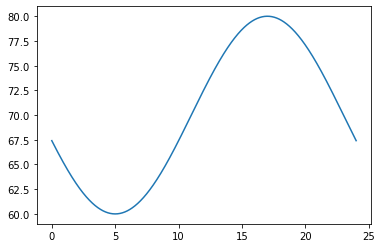

In [54]:
Tmin = 60
Tmax = 80 

Am = (Tmax - Tmin)/2
Mn = (Tmax + Tmin)/2
ω = np.pi/(60*12)  #t in minutes 
Temp = lambda t: Mn+Am*np.cos(ω*(t-17*60))

tran = np.linspace(0,24,1000)
plt.plot(tran,Temp(60*tran))

In [65]:
ω = np.pi/(60*12)  #time in minutes 

def TempAtTime(t,tempran):
    Tmin, Tmax = tempran
    Am = (Tmax - Tmin)/2
    Mn = (Tmax + Tmin)/2
    return Mn+Am*np.cos(ω*(t-17*60))  #max at 5 p.m. (so min at 5 a.m.)

IC_ran = (40,110)
HC_ran = (70,-20)

def TempToScaler(temp, ran, β = 0.1 ):
    p = (temp - ran[0])/(ran[1] - ran[0])
    return 1+β*np.tanh(p-0.5)

TempToScaler(100,IC_ran)

1.034269490696546

In [66]:
def PrecipToScaler_IC(precip, β = 0.1):
    return np.exp(-β*precip)
def PrecipToScaler_HC(precip, β = 0.1):
    return np.exp(β*precip)
def WindSpeedToScaler_IC(windspeed, β = 0.01):
    return np.exp(-β*windspeed)
def CloudCoverToScaler_IC(CC,β = 0.1 ):
    p = 1-CC/100
    return 1+β*np.tanh(p-0.5)
def CloudCoverToScaler_HC(CC,β = 0.1):
    p = CC/100
    return 1+β*np.tanh(p-0.5)
def RelativeHumidityToScaler(RH,β = 0.1):
    p = RH/100
    return 1+β*np.tanh(p-0.5)

In [67]:
## Generate Demands -- Single Instance of Schedules 
CollegeStudents = [CollegeStudent() for __ in range(N_students)]
WeekDays = ['M','T','W','R','F']

FeaturesAndDemands = DailyDf.copy()
FeaturesAndDemands['Demand'] = np.zeros(len(DailyDf))
pd.DataFrame( columns = [ 'Day','Tmax','Tmin','FeelsLike','Precipitation','WindSpeed',
                                               'CloudCover','RelativeHumidity', 'Demand'],
                                   index = DailyDf.index) 
fdmax = np.zeros(6)
fdmin = 1e10*np.ones(6) 
for idx, row in tqdm.tqdm(DailyDf.iterrows(), total=DailyDf.shape[0]):
    FeatureScalars = np.array(
                        [ PrecipToScaler_IC(row.Precipitation),
                          WindSpeedToScaler_IC(row.WindSpeed), 
                          CloudCoverToScaler_IC(row.CloudCover),
                          RelativeHumidityToScaler(row.RelativeHumidity),
                          TempToScaler(row.FeelsLike,IC_ran),
                          1.0 ] ) # for Max, Min temp scaling
    Tmax = row.Tmax
    Tmin = row.Tmin                    
    n_purchases = 0
    for student in CollegeStudents:
        snackTemp = TempAtTime(student.GetSnackTime(row.Day), (Tmin,Tmax))
        FeatureScalars[-1] = TempToScaler(snackTemp, IC_ran )
        n_purchases += student.BuyIceCream(row.Day, FeatureScales=FeatureScalars)                  
    FeaturesAndDemands.loc[idx,'Demand'] = n_purchases
    fdmax = np.maximum(FeatureScalars, fdmax)
    fdmin = np.minimum(FeatureScalars, fdmin)
FeaturesAndDemands.head(15) 

,Day,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,CloudCover,RelativeHumidity,Demand
Date time,,,,,,,,,
8/24/2020,M,86.5,66.4,88.9,0.00,6.4,57.1,77.67,1067.0
8/25/2020,T,87.8,66.8,89.2,0.00,10.4,41.4,74.50,327.0
8/26/2020,W,89.0,65.6,91.5,0.00,6.9,39.4,76.62,1079.0
8/27/2020,R,86.9,66.8,91.1,0.00,10.4,52.0,80.55,306.0
8/28/2020,F,85.4,68.2,90.3,0.42,6.5,49.8,82.33,1045.0
8/29/2020,M,82.6,70.2,85.9,0.58,12.8,67.5,83.84,947.0
8/30/2020,T,82.3,69.6,83.7,0.00,5.5,67.4,80.26,333.0
8/31/2020,W,82.6,69.7,86.3,0.25,4.6,71.3,86.65,1042.0
9/1/2020,R,82.8,70.1,87.7,0.29,5.3,60.9,87.33,322.0


In [68]:
fdmin, fdmax

(array([0.85214379, 0.78270454, 0.95378828, 0.98790944, 0.9201563 ,
        0.930502  ]),
 array([1.        , 0.97726248, 1.04621172, 1.04273908, 1.0248943 ,
        1.00151565]))

In [69]:
FeatureScalars

array([0.99104038, 0.83861798, 1.00947152, 1.00523521, 0.98357861,
       0.97690489])

In [70]:
FeaturesAndDemands.tail(20) 

,Day,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,CloudCover,RelativeHumidity,Demand
Date time,,,,,,,,,
4/11/2021,M,67.5,53.4,59.3,0.02,20.4,52.0,63.09,852.0
4/12/2021,T,74.1,41.0,42.3,0.00,20.0,1.8,46.99,280.0
4/13/2021,W,66.7,45.4,57.0,0.01,5.6,47.5,61.05,950.0
4/14/2021,R,75.6,46.8,60.1,0.13,14.2,58.6,66.72,270.0
4/15/2021,F,61.0,46.2,42.7,0.02,17.2,68.5,59.96,846.0
4/16/2021,M,62.1,31.8,44.9,0.00,9.1,35.2,56.66,916.0
4/17/2021,T,59.4,38.9,50.2,0.00,8.6,88.3,62.22,309.0
4/18/2021,W,64.0,46.1,46.2,0.00,7.6,87.2,53.36,913.0
4/19/2021,R,63.3,46.4,46.1,0.02,10.8,70.6,54.53,310.0


In [71]:
## Multiple Instances of Schedules to create Demands 
FeaturesAndDemands = DailyDf.copy()
for i in tqdm.trange(100):
    CollegeStudents = [CollegeStudent() for __ in range(N_students)]
    FeaturesAndDemands['Demand%s'%i] = np.zeros(len(DailyDf))
    pd.DataFrame( columns = [ 'Day','Tmax','Tmin','FeelsLike','Precipitation','WindSpeed',
                                                   'CloudCover','RelativeHumidity', 'Demand'],
                                       index = DailyDf.index) 
    fdmax = FeatureScalars
    fdmin = FeatureScalars 
    for idx, row in tqdm.tqdm(DailyDf.iterrows(), total=DailyDf.shape[0], leave=False):
        FeatureScalars = np.array(
                            [ PrecipToScaler_IC(row.Precipitation),
                              WindSpeedToScaler_IC(row.WindSpeed), 
                              CloudCoverToScaler_IC(row.CloudCover),
                              RelativeHumidityToScaler(row.RelativeHumidity),
                              TempToScaler(row.FeelsLike,IC_ran),
                              1.0 ] ) # for Max, Min temp scaling
        Tmax = row.Tmax
        Tmin = row.Tmin                    
        n_purchases = 0
        for student in CollegeStudents:
            snackTemp = TempAtTime(student.GetSnackTime(row.Day), (Tmin,Tmax))
            FeatureScalars[-1] = TempToScaler(snackTemp, IC_ran )
            n_purchases += student.BuyIceCream(row.Day, FeatureScales=FeatureScalars)                  
        FeaturesAndDemands.loc[idx,'Demand%s'%i] = n_purchases
        fdmax = np.maximum(FeatureScalars, fdmax)
        fdmin = np.minimum(FeatureScalars, fdmin)
        
## This Will Take Approximately 3(100) = 300 minutes (5 hours)

In [73]:
FeaturesAndDemands.head(10)

,Day,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,CloudCover,RelativeHumidity,Demand0,Demand1,...,Demand90,Demand91,Demand92,Demand93,Demand94,Demand95,Demand96,Demand97,Demand98,Demand99
Date time,,,,,,,,,,,,,,,,,,,,,
8/24/2020,M,86.5,66.4,88.9,0.00,6.4,57.1,77.67,959.0,1086.0,...,1045.0,985.0,1040.0,1037.0,1011.0,1067.0,1033.0,1011.0,1034.0,1032.0
8/25/2020,T,87.8,66.8,89.2,0.00,10.4,41.4,74.50,302.0,316.0,...,301.0,333.0,329.0,310.0,333.0,325.0,318.0,329.0,308.0,353.0
8/26/2020,W,89.0,65.6,91.5,0.00,6.9,39.4,76.62,1028.0,1059.0,...,1035.0,1119.0,1081.0,1070.0,1017.0,1080.0,1006.0,1051.0,1050.0,1047.0
8/27/2020,R,86.9,66.8,91.1,0.00,10.4,52.0,80.55,321.0,317.0,...,348.0,347.0,331.0,339.0,310.0,310.0,327.0,312.0,351.0,341.0
8/28/2020,F,85.4,68.2,90.3,0.42,6.5,49.8,82.33,995.0,1033.0,...,1003.0,1031.0,1009.0,1043.0,992.0,1047.0,984.0,1005.0,1007.0,1012.0
8/29/2020,M,82.6,70.2,85.9,0.58,12.8,67.5,83.84,916.0,920.0,...,910.0,910.0,963.0,900.0,925.0,954.0,942.0,919.0,897.0,943.0
8/30/2020,T,82.3,69.6,83.7,0.00,5.5,67.4,80.26,325.0,318.0,...,337.0,337.0,357.0,327.0,333.0,325.0,342.0,321.0,307.0,338.0
8/31/2020,W,82.6,69.7,86.3,0.25,4.6,71.3,86.65,1021.0,1005.0,...,1078.0,960.0,1057.0,1034.0,1038.0,1013.0,1014.0,1030.0,1050.0,1019.0
9/1/2020,R,82.8,70.1,87.7,0.29,5.3,60.9,87.33,326.0,336.0,...,348.0,297.0,361.0,321.0,339.0,346.0,317.0,319.0,307.0,352.0


In [79]:
one_hot = pd.get_dummies(FeaturesAndDemands['Day'])

In [81]:
FeaturesAndDemands = FeaturesAndDemands.drop('Day' , axis= 1)

In [82]:
FeaturesAndDemands = FeaturesAndDemands.join(one_hot)

In [83]:
FeaturesAndDemands.head(10)

,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,CloudCover,RelativeHumidity,Demand0,Demand1,Demand2,...,Demand95,Demand96,Demand97,Demand98,Demand99,F,M,R,T,W
Date time,,,,,,,,,,,,,,,,,,,,,
8/24/2020,86.5,66.4,88.9,0.00,6.4,57.1,77.67,959.0,1086.0,1024.0,...,1067.0,1033.0,1011.0,1034.0,1032.0,0,1,0,0,0
8/25/2020,87.8,66.8,89.2,0.00,10.4,41.4,74.50,302.0,316.0,305.0,...,325.0,318.0,329.0,308.0,353.0,0,0,0,1,0
8/26/2020,89.0,65.6,91.5,0.00,6.9,39.4,76.62,1028.0,1059.0,1046.0,...,1080.0,1006.0,1051.0,1050.0,1047.0,0,0,0,0,1
8/27/2020,86.9,66.8,91.1,0.00,10.4,52.0,80.55,321.0,317.0,325.0,...,310.0,327.0,312.0,351.0,341.0,0,0,1,0,0
8/28/2020,85.4,68.2,90.3,0.42,6.5,49.8,82.33,995.0,1033.0,1037.0,...,1047.0,984.0,1005.0,1007.0,1012.0,1,0,0,0,0
8/29/2020,82.6,70.2,85.9,0.58,12.8,67.5,83.84,916.0,920.0,895.0,...,954.0,942.0,919.0,897.0,943.0,0,1,0,0,0
8/30/2020,82.3,69.6,83.7,0.00,5.5,67.4,80.26,325.0,318.0,308.0,...,325.0,342.0,321.0,307.0,338.0,0,0,0,1,0
8/31/2020,82.6,69.7,86.3,0.25,4.6,71.3,86.65,1021.0,1005.0,1029.0,...,1013.0,1014.0,1030.0,1050.0,1019.0,0,0,0,0,1
9/1/2020,82.8,70.1,87.7,0.29,5.3,60.9,87.33,326.0,336.0,339.0,...,346.0,317.0,319.0,307.0,352.0,0,0,1,0,0


In [88]:
cols = list(FeaturesAndDemands.columns.values)

In [95]:
FeaturesAndDemands = FeaturesAndDemands[['M', 'T', 'W', 'R', 'F', 'Tmax', 'Tmin', 'FeelsLike',
       'Precipitation', 'WindSpeed', 'CloudCover', 'RelativeHumidity',
       'Demand0', 'Demand1', 'Demand2', 'Demand3', 'Demand4', 'Demand5',
       'Demand6', 'Demand7', 'Demand8', 'Demand9', 'Demand10', 'Demand11',
       'Demand12', 'Demand13', 'Demand14', 'Demand15', 'Demand16',
       'Demand17', 'Demand18', 'Demand19', 'Demand20', 'Demand21',
       'Demand22', 'Demand23', 'Demand24', 'Demand25', 'Demand26',
       'Demand27', 'Demand28', 'Demand29', 'Demand30', 'Demand31',
       'Demand32', 'Demand33', 'Demand34', 'Demand35', 'Demand36',
       'Demand37', 'Demand38', 'Demand39', 'Demand40', 'Demand41',
       'Demand42', 'Demand43', 'Demand44', 'Demand45', 'Demand46',
       'Demand47', 'Demand48', 'Demand49', 'Demand50', 'Demand51',
       'Demand52', 'Demand53', 'Demand54', 'Demand55', 'Demand56',
       'Demand57', 'Demand58', 'Demand59', 'Demand60', 'Demand61',
       'Demand62', 'Demand63', 'Demand64', 'Demand65', 'Demand66',
       'Demand67', 'Demand68', 'Demand69', 'Demand70', 'Demand71',
       'Demand72', 'Demand73', 'Demand74', 'Demand75', 'Demand76',
       'Demand77', 'Demand78', 'Demand79', 'Demand80', 'Demand81',
       'Demand82', 'Demand83', 'Demand84', 'Demand85', 'Demand86',
       'Demand87', 'Demand88', 'Demand89', 'Demand90', 'Demand91',
       'Demand92', 'Demand93', 'Demand94', 'Demand95', 'Demand96',
       'Demand97', 'Demand98', 'Demand99']]

In [98]:
FeaturesAndDemands.tail(15)

,M,T,W,R,F,Tmax,Tmin,FeelsLike,Precipitation,WindSpeed,...,Demand90,Demand91,Demand92,Demand93,Demand94,Demand95,Demand96,Demand97,Demand98,Demand99
Date time,,,,,,,,,,,,,,,,,,,,,
4/16/2021,1,0,0,0,0,62.1,31.8,44.9,0.00,9.1,...,922.0,935.0,925.0,948.0,936.0,872.0,909.0,911.0,878.0,904.0
4/17/2021,0,1,0,0,0,59.4,38.9,50.2,0.00,8.6,...,282.0,273.0,261.0,266.0,275.0,282.0,275.0,288.0,247.0,295.0
4/18/2021,0,0,1,0,0,64.0,46.1,46.2,0.00,7.6,...,892.0,885.0,881.0,899.0,904.0,830.0,900.0,859.0,917.0,908.0
4/19/2021,0,0,0,1,0,63.3,46.4,46.1,0.02,10.8,...,288.0,277.0,315.0,284.0,318.0,230.0,287.0,295.0,242.0,278.0
4/20/2021,0,0,0,0,1,72.8,38.5,55.9,0.00,14.8,...,855.0,880.0,896.0,891.0,917.0,900.0,858.0,864.0,951.0,911.0
4/21/2021,1,0,0,0,0,55.7,34.4,30.7,0.03,15.8,...,832.0,822.0,826.0,785.0,827.0,777.0,827.0,858.0,831.0,809.0
4/22/2021,0,1,0,0,0,53.6,25.8,31.1,0.00,14.3,...,274.0,301.0,289.0,284.0,272.0,251.0,276.0,256.0,266.0,306.0
4/23/2021,0,0,1,0,0,57.3,28.8,44.1,0.00,10.6,...,917.0,918.0,939.0,891.0,923.0,921.0,903.0,918.0,877.0,911.0
4/24/2021,0,0,0,1,0,57.4,44.0,43.8,0.76,8.5,...,281.0,270.0,263.0,266.0,251.0,273.0,271.0,294.0,253.0,267.0


In [97]:
FeaturesAndDemands.to_csv('FeaturesAndDemands.csv')

In [102]:
FeaturesAndDemands.shape

(250, 112)

In [110]:
fad = pd.concat([FeaturesAndDemands.iloc[:,:12]]*100, ignore_index= True)

In [111]:
df = pd.concat([FeaturesAndDemands["Demand%s"%i] for i in range(100)], ignore_index= True)

In [112]:
fad['Demand'] = df

In [114]:
fad.to_csv('FeaturesAndDemands.csv')

In [3]:
fad = pd.read_csv('FeaturesAndDemands.csv')
fad.shape

(25000, 14)

In [6]:
##Split data to train and test
train_I = fad.sample(frac=0.8,random_state=200) 
test_I = fad.drop(train_I.index)

In [4]:
train_I.shape, test_I.shape

NameError: name 'train_I' is not defined

In [8]:
train_I.to_csv("train_Ice.csv")
test_I.to_csv("test_Ice.csv")